###DATA PREPROCESSING

In [2]:
import pandas as pd
import numpy as np
file = 'family_financial_and_transactions_data.xlsx'
df = pd.read_excel(file)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16306 entries, 0 to 16305
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Family ID                16306 non-null  object        
 1   Member ID                16306 non-null  object        
 2   Transaction Date         16306 non-null  datetime64[ns]
 3   Category                 16306 non-null  object        
 4   Amount                   16306 non-null  float64       
 5   Income                   16306 non-null  int64         
 6   Savings                  16306 non-null  int64         
 7   Monthly Expenses         16306 non-null  int64         
 8   Loan Payments            16306 non-null  int64         
 9   Credit Card Spending     16306 non-null  int64         
 10  Dependents               16306 non-null  int64         
 11  Financial Goals Met (%)  16306 non-null  int64         
dtypes: datetime64[ns](1), float64(1)

In [3]:
df['Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')  # Convert dates
df['Income'] = pd.to_numeric(df['Income'], errors='coerce')  # Ensure numeric
df['Expenses'] = pd.to_numeric(df['Monthly Expenses'], errors='coerce')

In [4]:
df['Total Spending'] = df['Monthly Expenses'] + df['Loan Payments'] + df['Credit Card Spending']

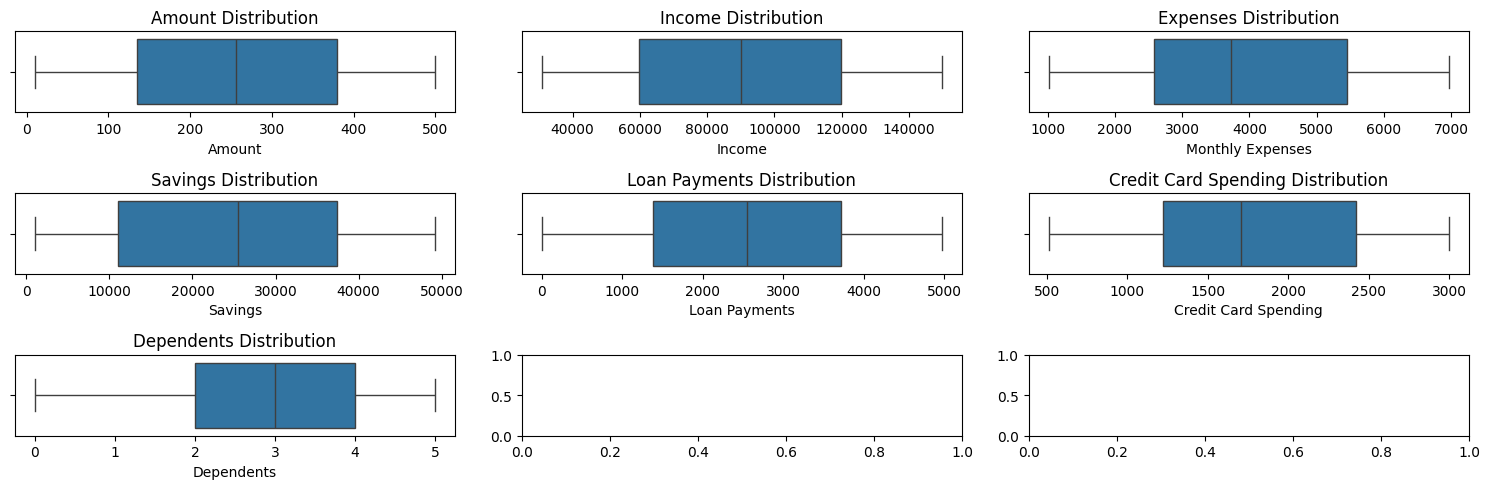

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(15, 5))
sns.boxplot(ax=axes[0, 0], x=df['Amount'])
axes[0, 0].set_title('Amount Distribution')
sns.boxplot(ax=axes[0, 1], x=df['Income'])
axes[0, 1].set_title('Income Distribution')

sns.boxplot(ax=axes[0, 2], x=df['Monthly Expenses'])
axes[0, 2].set_title('Expenses Distribution')

sns.boxplot(ax=axes[1, 0], x=df['Savings'])
axes[1, 0].set_title('Savings Distribution')

sns.boxplot(ax=axes[1, 1], x=df['Loan Payments'])
axes[1, 1].set_title('Loan Payments Distribution')

sns.boxplot(ax=axes[1, 2], x=df['Credit Card Spending'])
axes[1, 2].set_title('Credit Card Spending Distribution')

sns.boxplot(ax=axes[2, 0], x=df['Dependents'])
axes[2, 0].set_title('Dependents Distribution')
# Display the plots
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Income', 'Monthly Expenses', 'Savings', 'Loan Payments', 'Credit Card Spending']] = scaler.fit_transform(df[['Income', 'Monthly Expenses', 'Savings', 'Loan Payments', 'Credit Card Spending']])

###BUSINESS LOGIC

In [7]:
def calculate_financial_score(row):
    """
    Calculate the financial score for a family based on key metrics.
    Includes preprocessing for metrics to handle outliers and scaling.
    """
    # Extract values
    income = row['Income']
    savings = row['Savings']
    expenses = row['Monthly Expenses']
    loan_payments = row['Loan Payments']
    credit_card_spending = row['Credit Card Spending']
    goals_met = row['Financial Goals Met (%)']

    # Preprocessing: Convert absolute values to ratios where necessary
    savings_to_income_ratio = savings / income
    expenses_to_income_ratio = expenses / income
    loan_to_income_ratio = loan_payments / income
    credit_card_spending_ratio = credit_card_spending / income


    # Sub-scores
    # Positive indicator
    savings_to_income_score = min(savings_to_income_ratio * 25, 25)

    # Negative indicators (subtracted from 1)
    expenses_score = max((1 - expenses_to_income_ratio) * 20, 0)
    loan_score = max((1 - loan_to_income_ratio) * 15, 0)
    credit_card_score = max((1 - credit_card_spending_ratio / 0.2) * 15, 0)  # Penalize above 20%

    # Goals met proportional scoring
    goals_met_score = goals_met * 10 / 100  # Scaled to 10 points

    # Total score (capped at 100)
    total_score = min(
        savings_to_income_score + expenses_score + loan_score +
        credit_card_score + goals_met_score, 100
    )
    return total_score

def generate_insights(row):
    """
    Provide improvement suggestions based on financial score components.
    """
    insights = []
    if row['Savings'] / row['Income'] < 0.2:
        insights.append("Increase savings to at least 20% of your income.")
    if row['Monthly Expenses'] / row['Income'] > 0.5:
        insights.append("Reduce expenses to below 50% of your income.")
    if row['Loan Payments'] / row['Income'] > 0.2:
        insights.append("Reduce loan payments to below 20% of your income.")
    if row['Credit Card Spending'] > 0.2 * row['Income']:
        insights.append("Lower credit card spending to below 20% of income.")
    return " ".join(insights)


###TESTING ON DATASET

In [15]:
print(df.iloc[16305])
first_row_score = calculate_financial_score(df.iloc[16305])
print(first_row_score)
print(generate_insights(df.iloc[16305]))

Family ID                               FAM200
Member ID                       FAM200_Member6
Transaction Date           2024-10-27 00:00:00
Category                         Entertainment
Amount                                  475.34
Income                                0.115695
Savings                                 0.8934
Monthly Expenses                      0.551301
Loan Payments                         0.496278
Credit Card Spending                  0.932503
Dependents                                   4
Financial Goals Met (%)                     92
Date                       2024-10-27 00:00:00
Expenses                                  4296
Total Spending                            9597
Name: 16305, dtype: object
34.2
Reduce expenses to below 50% of your income. Reduce loan payments to below 20% of your income. Lower credit card spending to below 20% of income.


###TESTING ON A SAMPLE DATASET

In [9]:
import pandas as pd

# Sample data (replace with your dataset)
data = {
    'Family_ID': [1, 2, 3],
    'Income': [5000, 40000, 400],
    'Savings': [2500, 55500, 150],
    'Monthly Expenses': [2000, 63500, 300],
    'Loan Payments': [500, 2000, 70],
    'Credit Card Spending': [300, 3200, 80],
    'Financial Goals Met (%)': [80, 50, 70]
}
df_2 = pd.DataFrame(data)

# Calculate financial scores
df_2['Financial_Score'] = df_2.apply(calculate_financial_score, axis=1)
df_2['Rank'] = df_2['Financial_Score'].rank(ascending=False, method='dense').astype(int)

# Sort families by rank
df_2 = df_2.sort_values(by='Rank')

print(df_2[['Family_ID', 'Financial_Score', 'Rank']])

df_2['Insights'] = df_2.apply(generate_insights, axis=1)

# Display insights
print(df_2[['Family_ID', 'Financial_Score', 'Insights']])

   Family_ID  Financial_Score  Rank
0          1            56.50     1
1          2            53.25     2
2          3            33.75     3
   Family_ID  Financial_Score                                      Insights
0          1            56.50                                              
1          2            53.25  Reduce expenses to below 50% of your income.
2          3            33.75  Reduce expenses to below 50% of your income.


###VISUALIZATIONS

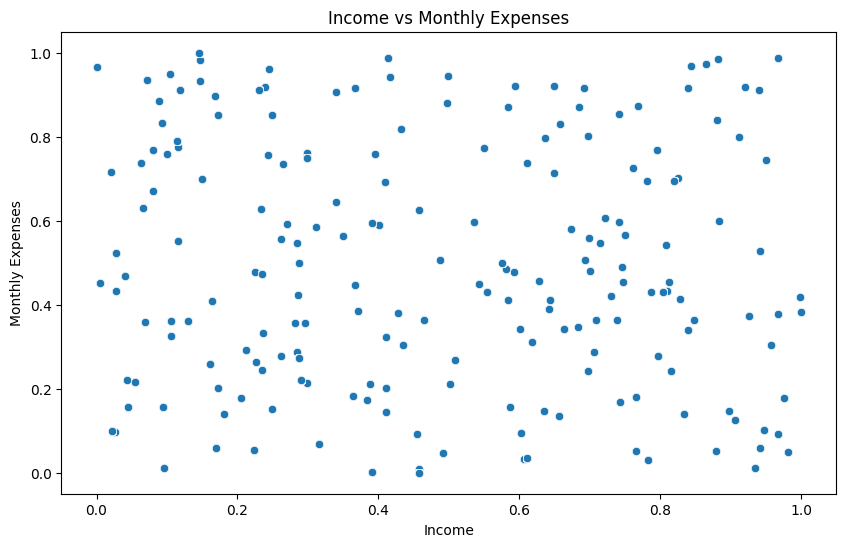

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for Income vs Monthly Expenses
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Income'], y=df['Monthly Expenses'], data=df)
plt.title('Income vs Monthly Expenses')
plt.xlabel('Income')
plt.ylabel('Monthly Expenses')
plt.show()

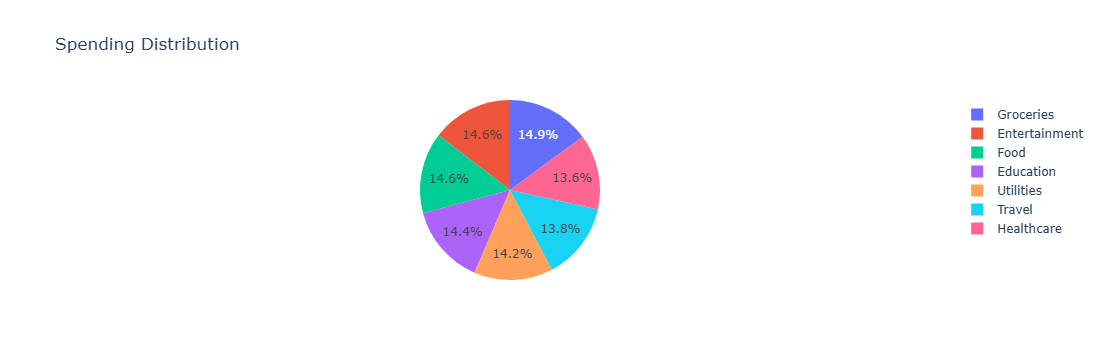

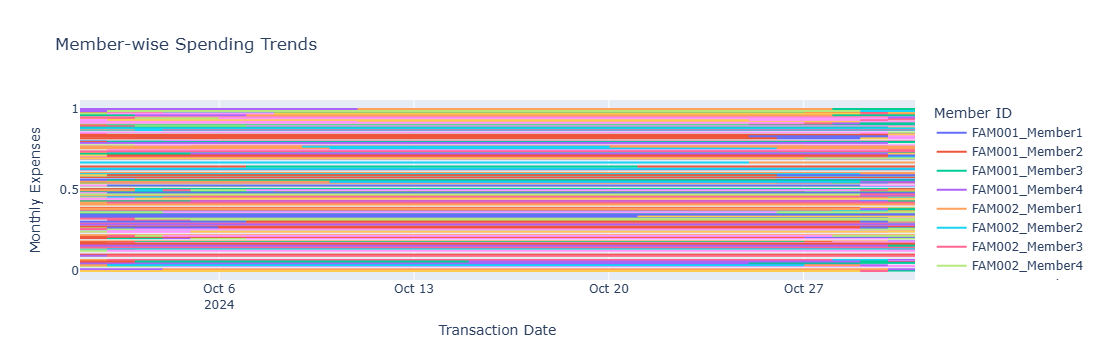

In [17]:
import plotly.express as px

# Spending distribution
fig = px.pie(df, values='Monthly Expenses', names='Category', title='Spending Distribution')
fig.show()


# Member-wise spending trends
fig = px.line(df, x='Transaction Date', y='Monthly Expenses', color='Member ID', title='Member-wise Spending Trends')
fig.show()